In [125]:
from library.chemistry import Species, Equilibrium
from library.equilibria import EqSystem, NumSysLog, NumSysLin
import numpy as np
import sympy as sp
sp.init_printing()
from operator import mul
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt

In [126]:
substance_names = ['H+', 'OH-', 'NH4+', 'NH3', 'H2O']
subst = {n: Species.from_formula(n) for n in substance_names}
assert [subst[n].charge for n in substance_names] == [1, -1, 1, 0, 0], "Charges of substances"
print(u'Composition of %s: %s' % (subst['NH3'].unicode_name, subst['NH3'].composition))

Composition of NH₃: {7: 1, 1: 3}


In [127]:
init_conc = {'H+': 1e-7, 'OH-': 1e-7, 'NH4+': 1e-7, 'NH3': 1.0, 'H2O': 55.5}
x0 = [init_conc[k] for k in substance_names]
H2O_c = init_conc['H2O']
w_autop = Equilibrium({'H2O': 1}, {'H+': 1, 'OH-': 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({'NH4+': 1}, {'H+': 1, 'NH3': 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr
[(k, init_conc[k]) for k in substance_names]

[('H+', 1e-07), ('OH-', 1e-07), ('NH4+', 1e-07), ('NH3', 1.0), ('H2O', 55.5)]

In [128]:
eqsys = EqSystem(equilibria, subst)
eqsys

In [129]:
ny = len(substance_names)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
K = Kw, Ka = sp.symbols('K_w K_a')
w_autop.param = Kw
NH4p_pr.param = Ka
ss = sp.symarray('s', ny)
ms = sp.symarray('m', ny)

In [130]:
numsys_log = NumSysLog(eqsys, backend=sp)
f = numsys_log.f(y, list(i)+list(K))
f

In [131]:
numsys_lin = NumSysLin(eqsys, backend=sp)
numsys_lin.f(y, i)

In [132]:
A, ks = eqsys.stoichs_constants(False, backend=sp)
[reduce(mul, [b**e for b, e in zip(y, row)]) for row in A]

In [106]:
from pyneqsys.symbolic import SymbolicSys
subs = list(zip(i, x0)) + [(Kw, 10**-14), (Ka, 10**-9.26)]
numf = [_.subs(subs) for _ in f]
neqs = SymbolicSys(list(y), numf)
neqs.solve([0, 0, 0, 0, 0], solver='scipy')

(array([-3.62343921e+01, -1.33889952e-07, -2.33889967e-07, -1.49124544e+01,
         3.99820071e+00]),
  message: The relative error between two consecutive iterates is at most 0.000000
  success: True
   status: 2
      fun: [ 0.000e+00  0.000e+00 -1.421e-14  1.421e-14  1.332e-15
             1.421e-14]
        x: [-3.623e+01 -1.339e-07 -2.339e-07 -1.491e+01  3.998e+00]
    cov_x: [[ 2.430e+00  1.415e+00 ...  1.826e+00 -1.499e-02]
            [ 1.415e+00  1.400e+00 ...  8.147e-01 -1.468e-02]
            ...
            [ 1.826e+00  8.147e-01 ...  2.622e+00 -1.132e-02]
            [-1.499e-02 -1.468e-02 ... -1.132e-02  3.142e-04]]
   method: lm
     nfev: 18
     njev: 13
     fjac: [[-9.440e+01  0.000e+00 ...  0.000e+00  5.773e-01]
            [-1.732e+00 -2.828e+00 ...  3.535e-01 -3.498e-01]
            ...
            [-1.059e-02 -3.471e-01 ...  5.330e-01 -2.315e-01]
            [-5.783e-07  3.535e-01 ... -6.175e-01 -9.495e-01]]
     ipvt: [4 2 1 0 3]
      qtf: [-3.651e-12 -2.250e-

In [107]:
j = sp.Matrix(1, len(f), lambda _, q: f[q]).jacobian(y)
init_conc_j = {'H+': 1e-10, 'OH-': 1e-7, 'NH4+': 1e-7, 'NH3': 1.0, 'H2O': 55.5}
xj = eqsys.as_per_substance_array(init_conc_j)
jarr = np.array(j.subs(dict(zip(y, xj))).subs({Kw: 1e-14, Ka: 10**-9.26}).subs(
            dict(zip(i, xj))))
jarr = np.asarray(jarr, dtype=np.float64)
np.log10(np.linalg.cond(jarr))

In [109]:
eqsys.composition_balance_vectors()

In [110]:
numsys_rref_log = NumSysLog(eqsys, True, True, backend=sp)
numsys_rref_log.f(y, list(i)+list(K))

In [111]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
for rxn in eqsys.rxns:
    rxn.param = rxn.param.subs({Kw: 1e-14, Ka: 10**-9.26})

In [112]:
x, res, sane = eqsys.root(init_conc, rref_equil=True, rref_preserv=True)
x, res['success'], sane

(array([1.7739e-11, 5.5469e+01, 9.6873e-01, 3.1270e-02, 3.1270e-02]),
 True,
 True)

In [113]:
x, res, sane = eqsys.root(init_conc, x0=eqsys.as_per_substance_array(
        {'H+': 1e-11, 'OH-': 1e-3, 'NH4+': 1e-3, 'NH3': 1.0, 'H2O': 55.5}))
res['success'], sane

(True, True)

In [114]:
init_conc

{'H+': 1e-07, 'OH-': 1e-07, 'NH4+': 1e-07, 'NH3': 1.0, 'H2O': 55.5}

In [115]:
nc=60
Hp_0 = np.logspace(-3, 0, nc)
def plot_rref(**kwargs):
    fig, axes = plt.subplots(2, 2, figsize=(16, 6), subplot_kw=dict(xscale='log', yscale='log'))
    return [eqsys.roots(init_conc, Hp_0, 'H+', plot_kwargs={'ax': axes.flat[i]}, rref_equil=e,
                        rref_preserv=p, **kwargs) for i, (e, p) in enumerate(product(*[[False, True]]*2))]

e:\anaconda3\envs\chemical_assistant_env\Lib\site-packages\pyneqsys\plotting.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1), **kwargs)


[True, True, True, True]

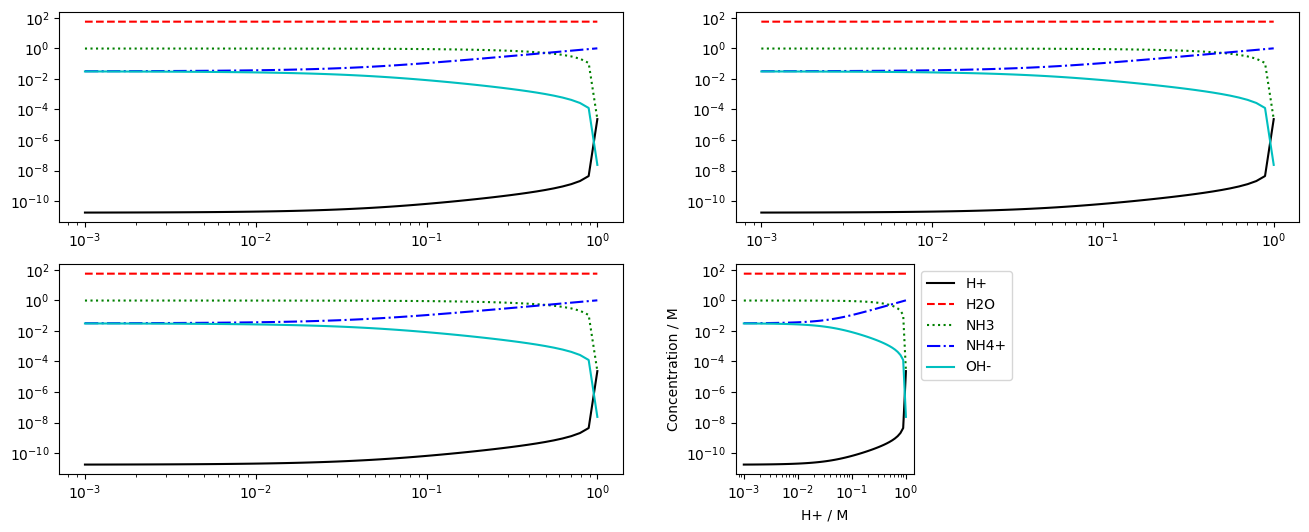

In [116]:
res_lin = plot_rref(method='lm')
[all(_[2]) for _ in res_lin]

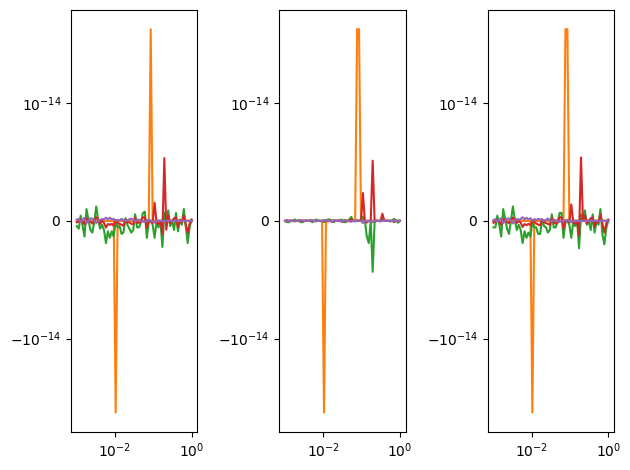

In [120]:
for col_id in range(len(substance_names)):
    for i in range(1, 4):
        plt.subplot(1, 3, i, xscale='log')
        plt.gca().set_yscale('symlog', linthresh=1e-14)  # Changed from linthreshy to linthresh
        plt.plot(Hp_0, res_lin[0][0][:, col_id] - res_lin[i][0][:, col_id])
plt.tight_layout()


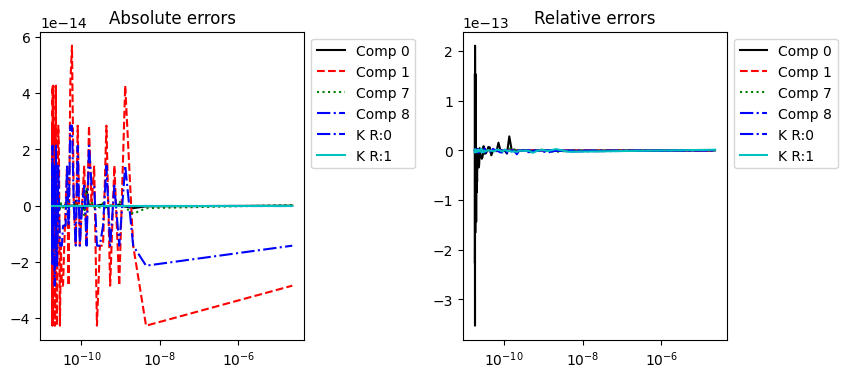

In [118]:
eqsys.plot_errors(res_lin[0][0], init_conc, Hp_0, 'H+')

In [119]:
init_conc, eqsys.ns

({'H+': 1e-07, 'OH-': 1e-07, 'NH4+': 1e-07, 'NH3': 1.0, 'H2O': 55.5}, 5)

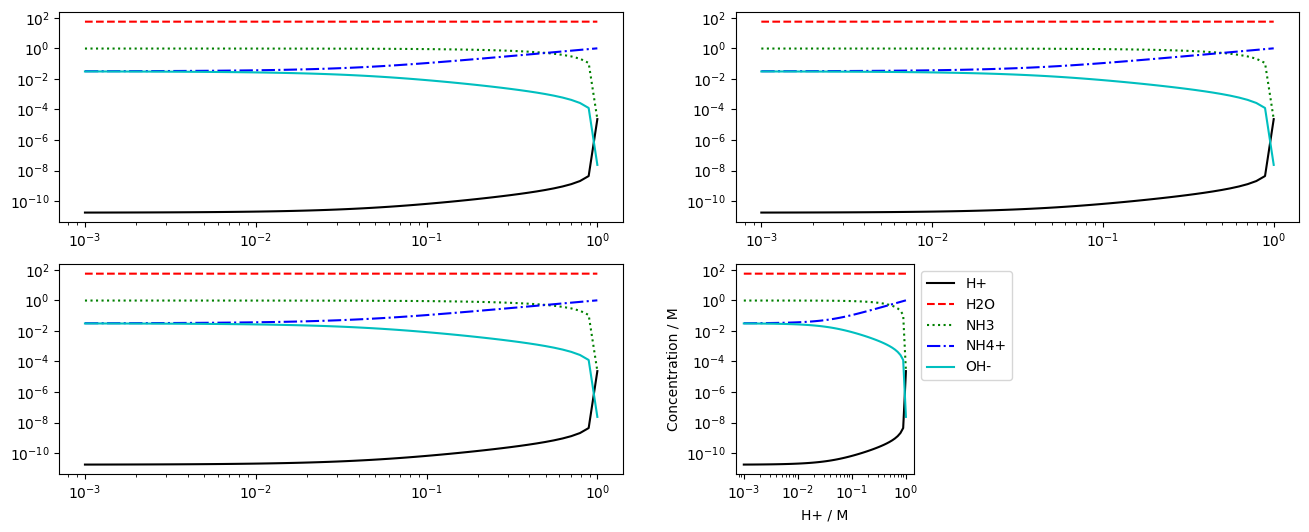

In [122]:
res_log = plot_rref(NumSys=NumSysLog)

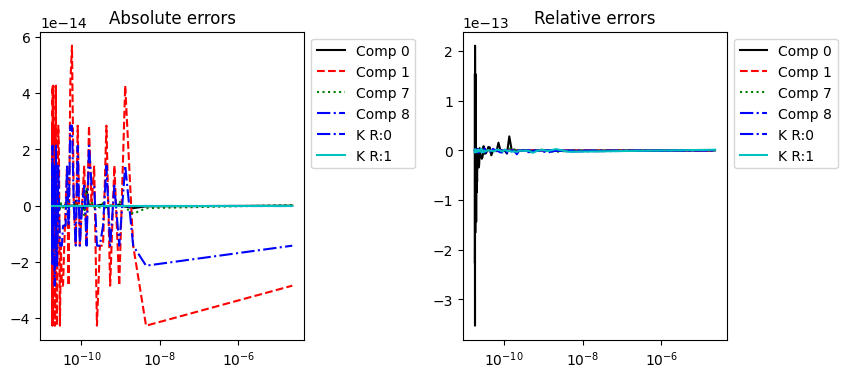

In [123]:
eqsys.plot_errors(res_log[0][0], init_conc, Hp_0, 'H+')

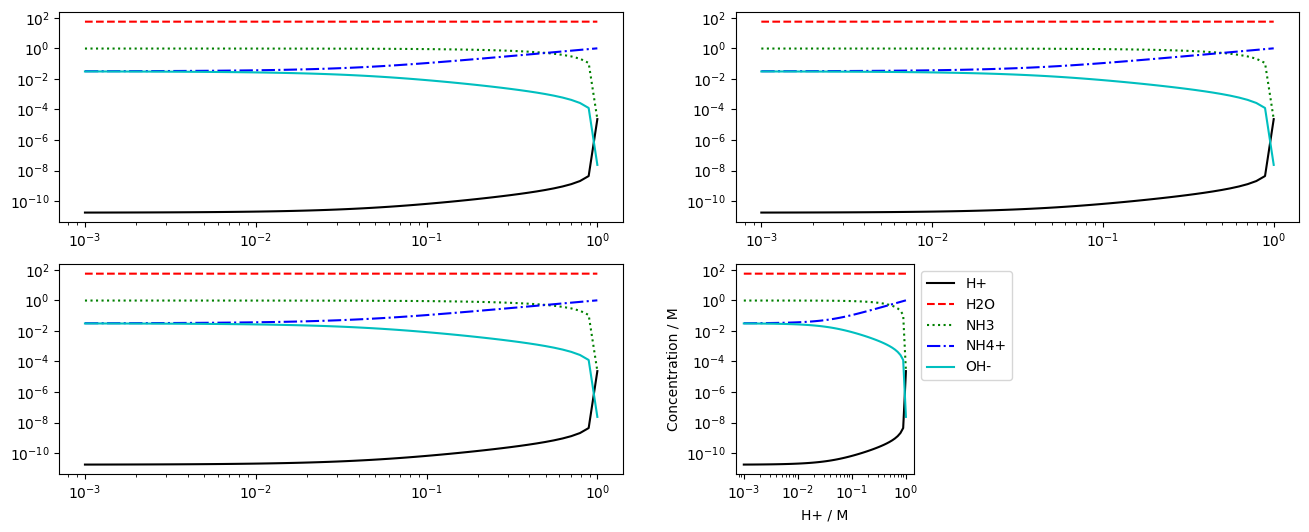

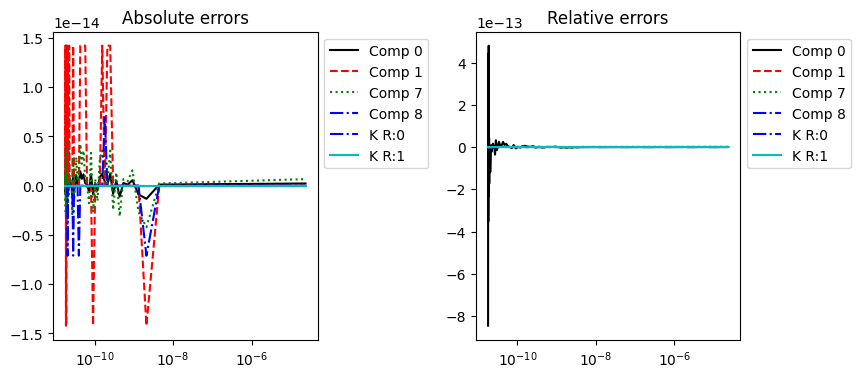

In [124]:
res_log_lin = plot_rref(NumSys=(NumSysLog, NumSysLin))
eqsys.plot_errors(res_log_lin[0][0], init_conc, Hp_0, 'H+')